In [33]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

In [34]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertTokenizerFast, BertForTokenClassification, AdamW, BertConfig, get_scheduler
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm # 과정 보여주는 라이브러리 (멘토링에서 알려줌)
import matplotlib.pyplot as plt

# 이해를 높히기 위해 전부다 주석을 달아가면서 진행

# 설정용
class Config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 16
    VAL_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 3e-5
    MODEL_NAME = 'bert-base-uncased'
    NUM_LABELS = None  # 나중에 데이터 셋 기반으로 채울 예정

# 현재 cuda만 사용하고 있긴 하지만, 배운김에 넣음
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [35]:
# 데이터 불러오는 단계
def load_data(file_path):
    # CSV 파일에서 데이터를 로드하고, 결측값을 채움
    data = pd.read_csv(file_path, encoding='latin-1')

    print(data.head()) # 데이터의 첫 몇줄 확인, 결측값 채우기 전에 확인용

    data['Sentence #'] = data['Sentence #'].ffill()
    # 타겟은 Sentence #로 데이터 셋에서 문장을 구분하는 식별자
    # ffill(Foward Fill)로 결측값을 바로 이전 행의 값으로 채움
    # 즉 같은 문장 구분끼리는 같은 구분자를 가지게 됨

    print(data.head()) # 데이터의 첫 몇 줄을 확인하여 올바르게 로드되었는지 확인

    return data

file_path = "NER_dataset.csv"
data = load_data(file_path) # 데이터 불러오기

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O
    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [36]:
# 데이터 준비 단계
def prepare_data(data):
    label_list = data['Tag'].unique().tolist() # Tag에 값을 중복 제거한 유일값들만 추출해 리스트로 반환
    label_map = {label: idx for idx, label in enumerate(label_list)} # 리스트를 반복해 기존 Tag에 순번을 매겨 Tag : index 형식으로 숫자를 매핑
    data['Tag'] = data['Tag'].map(label_map) # 기존 data에 Tag 값을 숫자로 변환
    grouped = data.groupby('Sentence #').agg({'Word': list, 'Tag': list}) # 문장(Sentence #)별로 단어와 태그를 그룹화
    print(grouped.head()) # 그룹화 된 데이터 확인
    print(label_map) # 태그를 숫자로 매핑한 딕셔너리 확인
    return grouped, label_map # groupe: 문장 번호 기준으로 그룹화 된 데이터 프레임, label_map: 태그를 숫자로 매핑한 딕셔너리

grouped_data, label_map = prepare_data(data) # 데이터 준비
Config.NUM_LABELS = len(label_map)


                                                              Word  \
Sentence #                                                           
Sentence: 1      [Thousands, of, demonstrators, have, marched, ...   
Sentence: 10     [Iranian, officials, say, they, expect, to, ge...   
Sentence: 100    [Helicopter, gunships, Saturday, pounded, mili...   
Sentence: 1000   [They, left, after, a, tense, hour-long, stand...   
Sentence: 10000  [U.N., relief, coordinator, Jan, Egeland, said...   

                                                               Tag  
Sentence #                                                          
Sentence: 1      [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...  
Sentence: 10     [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
Sentence: 100    [0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ...  
Sentence: 1000                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
Sentence: 10000  [1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,...  
{'O': 0, 'B-geo': 1, 'B-gp

In [37]:
# 데이터셋을 학습용과 검증용으로 분리
train_texts, val_texts, train_tags, val_tags = train_test_split(
    grouped_data['Word'].values.tolist(),  # 그룹화 된 데이터에서 단어를 추출해 리스트로 분리
    grouped_data['Tag'].values.tolist(),  # 그룹화 된 데이터에서 태그를 추출해 리스트로 분리
    test_size=0.1, # 데이터 나눌 때 검증 데이터의 비율 (10%)
    random_state=42 # 결과 재현을 위해 랜덤 시드를 고정해서 설정함
)

# 분리된 데이터 확인
print("Train Samples:", len(train_texts)) # 학습용 단어 길이
print("Validation Samples:", len(val_texts)) # 테스트용 단어 길이
print("Example Training Data:", train_texts[0], train_tags[0]) # 데이터 일부 확인


Train Samples: 43163
Validation Samples: 4796
Example Training Data: ['Kremlin', 'officials', 'insisted', 'that', 'they', 'are', 'cracking', 'down', 'on', 'corporate', 'crime', '.'] [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:

# Dataset 기반으로 NER 학습용 Dataset으로 변경하는 용도
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_len):
        self.texts = texts # 문장 단위에 텍스트 데이터 리스트
        self.tags = tags # 문장 단위에 태그 데이터 리스트
        self.tokenizer = tokenizer # BERT 토크나이저 빠른 버전
        self.max_len = max_len # 모델 입력의 최대 길이. 현재 128

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] # 현재 인덱스에 해당하는 텍스트 가져옴
        tag = self.tags[idx] # 현재 인덱스에 해당하는 태그 가져옴

        # [S] 데이터 유효성 검사 추가
        # 형식 오류가 나서 데이터 통일을 위해 추가
        if not isinstance(text, list): # 리스트 형식이 아니면 예외 처리
            print(f"Invalid text format at index {idx}: {text}")
            text = [str(word) for word in text] if hasattr(text, '__iter__') else [str(text)]

        # 모든 단어를 문자열로 변환해 데이터 타입을 통일
        text = [str(word) for word in text]
        # [E] 데이터 유효성 검사 추가

        # 텍스트를 토크나이징해 BERT 입력 형식으로 변환하는 용도
        encoding = self.tokenizer(
            text, # 현재 인덱스에 해당하는 문장 단위 텍스트
            is_split_into_words=True, # 단어별로 분리된 입력 처리
            truncation=True, # max_len 초과하는 입력은 자르기
            padding='max_length', # max_len에 맞춰 패딩
            max_length=self.max_len, # 기준이 될 최대 입력 길이 설정
            return_tensors='pt' # PyTorch 텐서로 변환
        )

        # 토큰에 맞춰 태그를 재정렬
        labels = [-100] * len(encoding['input_ids'][0]) # 패딩 토큰에 대해 -100으로 초기화
        word_ids = encoding.word_ids() # 각 토큰이 원래 단어와 매핑되는 ID 가져옴

        for i, word_idx in enumerate(word_ids): # 토큰 단위로 반복
            if word_idx is not None and word_idx < len(tag):
                labels[i] = tag[word_idx] # 토큰이 실제 단어와 매핑되면 해당 태그를 할당

        return {
            'input_ids': encoding['input_ids'].squeeze(0), # BERT 입력 토큰 ID
            'attention_mask': encoding['attention_mask'].squeeze(0), # 패딩 여부를 나타내는 마스크
            'labels': torch.tensor(labels, dtype=torch.long) # 정렬된 태그(-100 포함)
        }



#tokenizer = BertTokenizer.from_pretrained(Config.MODEL_NAME)
tokenizer = BertTokenizerFast.from_pretrained(Config.MODEL_NAME) # 소중한 내 리소스를 위해 빠른 버전 사용
# BERT 모델에 입력 가능하도록 단어를 토큰으로 변화시켜주는 용도
# BERT는 ID, Attention MASK, Token Type을 요구해서 토크나이저를 사용해 변환

 # 기존 데이터셋을 기반으로 NERDataset 생성
train_dataset = NERDataset(train_texts, train_tags, tokenizer, Config.MAX_LEN)
val_dataset = NERDataset(val_texts, val_tags, tokenizer, Config.MAX_LEN)

# val도 어차피 내용은 똑같으니 sample은 하나만 확인
sample = train_dataset[0]
print("Sample Input IDs:", sample['input_ids'][:5]) # 단어를 숫자로 변환한 ID
print("Sample Attention Mask:", sample['attention_mask'][:5]) # 입력 단어에 대한 마스크 (패딩 여부)
print("Sample Labels:", sample['labels'][:5]) # 토큰화된 입력에 맞춰 조정된 NER 태그


Sample Input IDs: tensor([  101,  1047, 28578,  4115,  4584])
Sample Attention Mask: tensor([1, 1, 1, 1, 1])
Sample Labels: tensor([-100,    5,    5,    5,    0])


In [39]:

# 학습 및 검증 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, shuffle=True) # 학습용 데이터 섞기
val_loader = DataLoader(val_dataset, batch_size=Config.VAL_BATCH_SIZE)

# 데이터 로더 확인
batch = next(iter(train_loader))  # 확인용 첫 번째 배치 가져오기
print("Batch Input IDs:", batch['input_ids'].shape)
print("Batch Attention Mask:", batch['attention_mask'].shape)
print("Batch Labels:", batch['labels'].shape)


Batch Input IDs: torch.Size([16, 128])
Batch Attention Mask: torch.Size([16, 128])
Batch Labels: torch.Size([16, 128])


In [40]:

# 모델 초기화
model = BertForTokenClassification.from_pretrained(
    Config.MODEL_NAME,  # 사전 학습된 BERT 모델 이름 (현재: 'bert-base-uncased')
    num_labels=Config.NUM_LABELS  # 출력 레이블의 수 (이전에 데이터셋 Tag 기준으로 맞춰둠)
)
model.to(device)  # 모델을 GPU 또는 CPU로 이동

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
# 아 이거 torch.optim.AdamW로 바꿨어야 하는데. 다시 돌리기엔 리소스가 모자람....

# 학습 스케줄러 설정
scheduler = get_scheduler(
    "linear",  # 스케줄러 유형 (선형 감속 스케줄러)
    optimizer=optimizer,
    num_warmup_steps=0,  # 워밍업 단계 수
    num_training_steps=len(train_loader) * Config.EPOCHS  # 총 학습 단계 수
)

# 사전 학습되지 않은 모델 초기화
untrained_config = BertConfig.from_pretrained(Config.MODEL_NAME, num_labels=Config.NUM_LABELS)
untrained_model = BertForTokenClassification(untrained_config)
untrained_model.to(device)

# 동일한 옵티마이저 및 스케줄러 설정(위와 동일하니 설명은 생략)
untrained_optimizer = AdamW(untrained_model.parameters(), lr=Config.LEARNING_RATE)
untrained_scheduler = get_scheduler(
    "linear",
    optimizer=untrained_optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * Config.EPOCHS
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:


# 학습 기능
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train() # 모델을 학습 모드로 설정
    total_loss = 0

    for batch in tqdm(data_loader): # 배치 단위로 데이터를 처리하면서 과정 확인을 위해 tqdm 사용
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss # 손실 계산

        optimizer.zero_grad() # 그래디언트 초기화
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 업데이트
        scheduler.step() # 학습률 조정

        total_loss += loss.item()

    return total_loss / len(data_loader) # 평균 손실 반환

# 평가 기능
def evaluate(model, data_loader, device):
    model.eval() # 모델을 평가 모드로 설정
    true_labels, pred_labels = [], [] # 실제 태그와 예측 태그를 저장하는 용도

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device) # 입력 토큰 ID를 GPU/CPU로 이동
            attention_mask = batch['attention_mask'].to(device) # 패딩 마스크를 GPU/CPU로 이동
            labels = batch['labels'].to(device) # 실제 태그를 GPU/CPU로 이동

            outputs = model(input_ids, attention_mask=attention_mask) # 모델 예측 수행
            logits = outputs.logits # 출력값(로짓)

            predictions = torch.argmax(logits, dim=2) # 로짓에서 가장 높은 확률의 클래스 선택

            for label, prediction, mask in zip(labels, predictions, attention_mask):
                label = label[mask == 1].cpu().numpy() # mask가 1인 위치(실제 단어)에 대해서만 태그를 추출하고 패딩토큰은 제외
                prediction = prediction[mask == 1].cpu().numpy() # 위와 동일

                true_labels.extend(label[label != -100]) # -100태그(무시 토큰 패딩)은 제외하고 true_labels에 담음
                pred_labels.extend(prediction[label != -100]) # 같은 방식으로 예측값 담음

    # 각 클래스(태그)에 대한 Precision, Recall, F1-Score 계산해줌
    return classification_report(true_labels, pred_labels, target_names=list(label_map.keys()), zero_division=0)

# 평가 결과를 DataFrame으로 변환하는 함수
def report_to_df(report):
    """
    classification_report의 텍스트 출력을 DataFrame으로 변환하는 함수.
    클래스별 Precision, Recall, F1-Score, Support를 추출.
    """
    report_data = []  # 결과를 담을 리스트
    lines = report.split('\n')  # 줄 단위로 나눔

    # 클래스별 Precision, Recall, F1-Score 추출
    for line in lines[2:-3]:  # 클래스별 결과만 선택
        if not line.strip():  # 빈 줄 건너뛰기
            continue
        row_data = line.split()
        # 잘못된 형식의 줄을 건너뜀
        if len(row_data) < 5:
            print(f"line skip: {line}")  # 디버깅용 메시지
            continue
        row = {
            'class': row_data[0],  # 클래스 이름
            'precision': float(row_data[1]),  # Precision
            'recall': float(row_data[2]),  # Recall
            'f1_score': float(row_data[3]),  # F1-Score
            'support': int(row_data[4])  # Support
        }
        report_data.append(row)

    # DataFrame으로 변환
    return pd.DataFrame.from_records(report_data)

# 손실 및 평가 결과 저장용 리스트
train_losses = []
eval_reports = []
# 사전 학습된 모델 학습 루프
for epoch in range(Config.EPOCHS):
    print(f"Epoch {epoch + 1}/{Config.EPOCHS} - Pre-trained Model")
    # 학습 단계
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss}")
    train_losses.append(train_loss)  # 손실 저장

    # 평가 단계
    eval_report = evaluate(model, val_loader, device)
    print(f"Evaluation Report:\n{eval_report}")
    eval_reports.append(report_to_df(eval_report))  # 평가 결과를 DataFrame으로 저장

# 손실 및 평가 결과 저장용 리스트
untrained_train_losses = []
untrained_eval_reports = []
# 사전 학습되지 않은 모델 학습 루프
for epoch in range(Config.EPOCHS):
    print(f"Epoch {epoch + 1}/{Config.EPOCHS} - Untrained Model")
    # 학습 단계
    train_loss = train_epoch(untrained_model, train_loader, untrained_optimizer, untrained_scheduler, device)
    print(f"Train Loss: {train_loss}")
    untrained_train_losses.append(train_loss)  # 손실 저장

    # 평가 단계
    eval_report = evaluate(untrained_model, val_loader, device)
    print(f"Evaluation Report:\n{eval_report}")
    untrained_eval_reports.append(report_to_df(eval_report))  # 평가 결과를 DataFrame으로 저장

# 결과값에 대해서
# Precision: 예측한 태그 중 정답인 비율
# Recall: 실제 태그 중 모델이 올바르게 예측한 비율
# F1-Score: Precision, Recall 간에 조화 평균
# Support: 각 태그별 실제 데이터 개수

# 리소스 아까워서라도 일단 저장해봄(안씀)
torch.save(model.state_dict(), "ner_model.pt")


Epoch 1/5 - Pre-trained Model


100%|██████████| 2698/2698 [04:03<00:00, 11.08it/s]


Train Loss: 0.18323577485779774


100%|██████████| 600/600 [00:12<00:00, 49.45it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     94743
       B-geo       0.84      0.90      0.86      5908
       B-gpe       0.96      0.91      0.94      1735
       B-per       0.84      0.83      0.83      2625
       I-geo       0.69      0.80      0.74       861
       B-org       0.76      0.68      0.72      3429
       I-org       0.74      0.62      0.67      2102
       B-tim       0.92      0.85      0.89      2207
       B-art       0.00      0.00      0.00        80
       I-art       0.00      0.00      0.00        43
       I-per       0.82      0.94      0.88      3148
       I-gpe       1.00      0.65      0.79        20
       I-tim       0.79      0.78      0.78       625
       B-nat       0.50      0.08      0.14        24
       B-eve       0.55      0.28      0.37        40
       I-eve       0.53      0.19      0.28        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:02<00:00, 11.14it/s]


Train Loss: 0.11192740995666113


100%|██████████| 600/600 [00:12<00:00, 48.09it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     94743
       B-geo       0.84      0.92      0.88      5908
       B-gpe       0.94      0.93      0.94      1735
       B-per       0.86      0.84      0.85      2625
       I-geo       0.66      0.84      0.74       861
       B-org       0.82      0.66      0.73      3429
       I-org       0.77      0.64      0.70      2102
       B-tim       0.89      0.89      0.89      2207
       B-art       0.21      0.10      0.13        80
       I-art       0.50      0.02      0.04        43
       I-per       0.84      0.94      0.89      3148
       I-gpe       0.93      0.65      0.76        20
       I-tim       0.81      0.80      0.81       625
       B-nat       0.29      0.29      0.29        24
       B-eve       0.48      0.28      0.35        40
       I-eve       0.80      0.19      0.31        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:03<00:00, 11.06it/s]


Train Loss: 0.08197626312628521


100%|██████████| 600/600 [00:12<00:00, 48.22it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     94743
       B-geo       0.87      0.91      0.89      5908
       B-gpe       0.95      0.94      0.95      1735
       B-per       0.82      0.87      0.85      2625
       I-geo       0.80      0.76      0.78       861
       B-org       0.83      0.67      0.74      3429
       I-org       0.78      0.64      0.71      2102
       B-tim       0.89      0.89      0.89      2207
       B-art       0.21      0.19      0.20        80
       I-art       0.25      0.02      0.04        43
       I-per       0.83      0.95      0.89      3148
       I-gpe       1.00      0.60      0.75        20
       I-tim       0.80      0.77      0.78       625
       B-nat       0.50      0.12      0.20        24
       B-eve       0.55      0.30      0.39        40
       I-eve       0.65      0.26      0.37        42
       I-nat       1.00      0.29      0.44         7

    acc

100%|██████████| 2698/2698 [04:03<00:00, 11.06it/s]


Train Loss: 0.05886933865219636


100%|██████████| 600/600 [00:12<00:00, 48.13it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     94743
       B-geo       0.88      0.89      0.89      5908
       B-gpe       0.94      0.94      0.94      1735
       B-per       0.84      0.86      0.85      2625
       I-geo       0.80      0.76      0.78       861
       B-org       0.77      0.74      0.76      3429
       I-org       0.74      0.73      0.73      2102
       B-tim       0.89      0.90      0.90      2207
       B-art       0.24      0.21      0.23        80
       I-art       0.29      0.05      0.08        43
       I-per       0.87      0.90      0.89      3148
       I-gpe       0.92      0.60      0.73        20
       I-tim       0.78      0.82      0.80       625
       B-nat       0.56      0.21      0.30        24
       B-eve       0.44      0.30      0.36        40
       I-eve       0.50      0.31      0.38        42
       I-nat       1.00      0.29      0.44         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.06it/s]


Train Loss: 0.04396085319264769


100%|██████████| 600/600 [00:12<00:00, 47.82it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     94743
       B-geo       0.87      0.90      0.89      5908
       B-gpe       0.95      0.94      0.94      1735
       B-per       0.84      0.86      0.85      2625
       I-geo       0.77      0.78      0.78       861
       B-org       0.79      0.73      0.76      3429
       I-org       0.76      0.70      0.73      2102
       B-tim       0.90      0.90      0.90      2207
       B-art       0.24      0.20      0.22        80
       I-art       0.29      0.05      0.08        43
       I-per       0.86      0.92      0.89      3148
       I-gpe       0.92      0.60      0.73        20
       I-tim       0.80      0.80      0.80       625
       B-nat       0.60      0.25      0.35        24
       B-eve       0.48      0.33      0.39        40
       I-eve       0.46      0.31      0.37        42
       I-nat       1.00      0.43      0.60         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.04it/s]


Train Loss: 0.39474072824580925


100%|██████████| 600/600 [00:12<00:00, 48.02it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.96      0.99      0.97     94743
       B-geo       0.73      0.79      0.76      5908
       B-gpe       0.92      0.80      0.86      1735
       B-per       0.77      0.53      0.63      2625
       I-geo       0.60      0.48      0.53       861
       B-org       0.74      0.45      0.56      3429
       I-org       0.70      0.28      0.40      2102
       B-tim       0.86      0.70      0.77      2207
       B-art       0.00      0.00      0.00        80
       I-art       0.00      0.00      0.00        43
       I-per       0.55      0.89      0.68      3148
       I-gpe       0.80      0.20      0.32        20
       I-tim       0.83      0.20      0.32       625
       B-nat       0.00      0.00      0.00        24
       B-eve       0.71      0.12      0.21        40
       I-eve       0.00      0.00      0.00        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.04it/s]


Train Loss: 0.23865669108568252


100%|██████████| 600/600 [00:12<00:00, 48.08it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.97      0.99      0.98     94743
       B-geo       0.81      0.82      0.81      5908
       B-gpe       0.94      0.88      0.91      1735
       B-per       0.77      0.70      0.73      2625
       I-geo       0.81      0.49      0.61       861
       B-org       0.71      0.60      0.65      3429
       I-org       0.64      0.54      0.58      2102
       B-tim       0.88      0.73      0.80      2207
       B-art       0.00      0.00      0.00        80
       I-art       0.00      0.00      0.00        43
       I-per       0.80      0.79      0.80      3148
       I-gpe       0.83      0.25      0.38        20
       I-tim       0.66      0.60      0.63       625
       B-nat       0.50      0.04      0.08        24
       B-eve       0.71      0.12      0.21        40
       I-eve       0.00      0.00      0.00        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.03it/s]


Train Loss: 0.18241328894374015


100%|██████████| 600/600 [00:12<00:00, 47.97it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.97      0.99      0.98     94743
       B-geo       0.82      0.84      0.83      5908
       B-gpe       0.93      0.89      0.91      1735
       B-per       0.76      0.75      0.76      2625
       I-geo       0.83      0.54      0.65       861
       B-org       0.74      0.60      0.66      3429
       I-org       0.71      0.48      0.57      2102
       B-tim       0.89      0.78      0.83      2207
       B-art       0.00      0.00      0.00        80
       I-art       0.00      0.00      0.00        43
       I-per       0.77      0.90      0.83      3148
       I-gpe       0.88      0.35      0.50        20
       I-tim       0.70      0.70      0.70       625
       B-nat       0.40      0.17      0.24        24
       B-eve       0.43      0.15      0.22        40
       I-eve       0.50      0.02      0.05        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.03it/s]


Train Loss: 0.14729305073754204


100%|██████████| 600/600 [00:12<00:00, 47.78it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.98      0.98      0.98     94743
       B-geo       0.84      0.84      0.84      5908
       B-gpe       0.95      0.89      0.92      1735
       B-per       0.76      0.78      0.77      2625
       I-geo       0.77      0.61      0.68       861
       B-org       0.68      0.67      0.68      3429
       I-org       0.59      0.62      0.60      2102
       B-tim       0.88      0.80      0.84      2207
       B-art       0.00      0.00      0.00        80
       I-art       0.00      0.00      0.00        43
       I-per       0.80      0.88      0.84      3148
       I-gpe       0.88      0.35      0.50        20
       I-tim       0.65      0.75      0.70       625
       B-nat       0.28      0.29      0.29        24
       B-eve       0.37      0.17      0.24        40
       I-eve       0.25      0.07      0.11        42
       I-nat       0.00      0.00      0.00         7

    acc

100%|██████████| 2698/2698 [04:04<00:00, 11.04it/s]


Train Loss: 0.12081848664466067


100%|██████████| 600/600 [00:12<00:00, 47.78it/s]


Evaluation Report:
              precision    recall  f1-score   support

           O       0.98      0.99      0.98     94743
       B-geo       0.84      0.85      0.85      5908
       B-gpe       0.94      0.91      0.92      1735
       B-per       0.78      0.78      0.78      2625
       I-geo       0.74      0.67      0.71       861
       B-org       0.71      0.66      0.68      3429
       I-org       0.64      0.61      0.62      2102
       B-tim       0.87      0.82      0.84      2207
       B-art       0.33      0.03      0.05        80
       I-art       0.00      0.00      0.00        43
       I-per       0.81      0.88      0.85      3148
       I-gpe       0.88      0.35      0.50        20
       I-tim       0.71      0.74      0.73       625
       B-nat       0.31      0.21      0.25        24
       B-eve       0.33      0.17      0.23        40
       I-eve       0.38      0.12      0.18        42
       I-nat       0.00      0.00      0.00         7

    acc

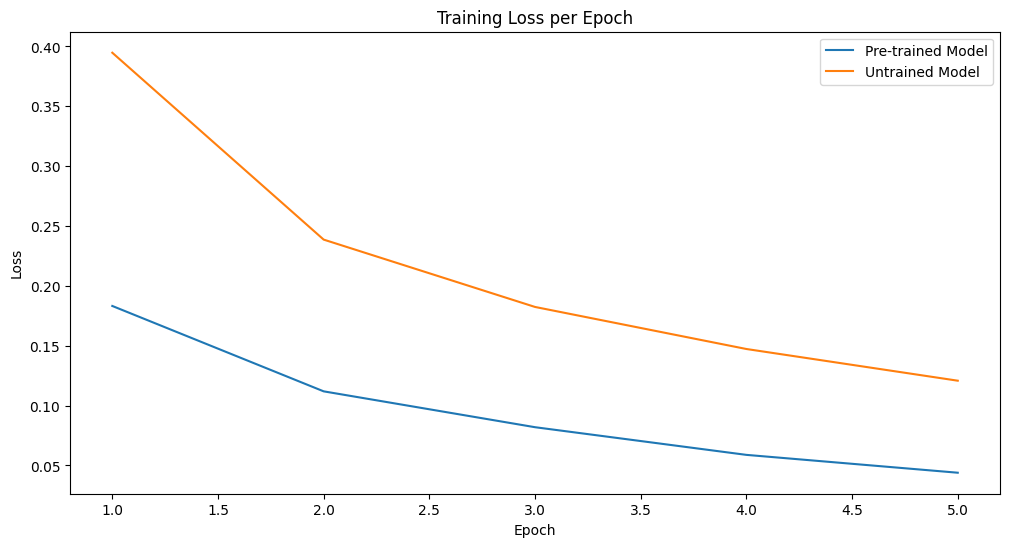

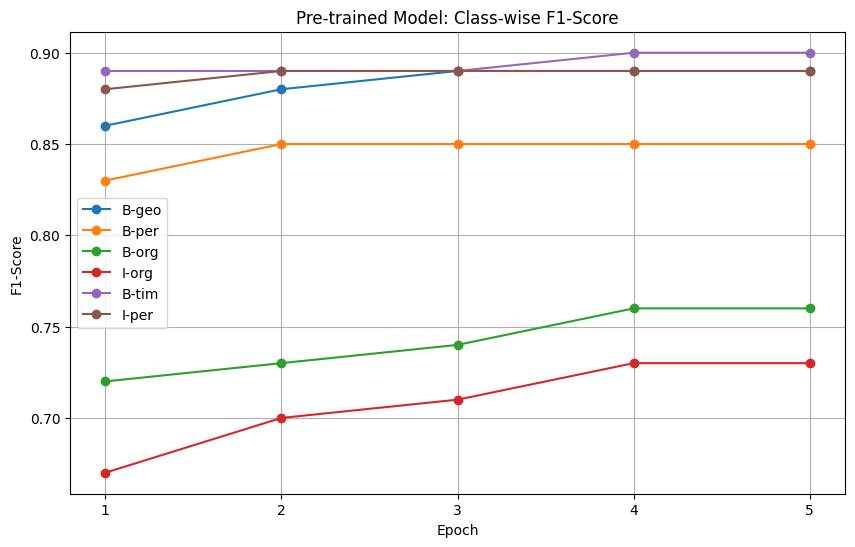

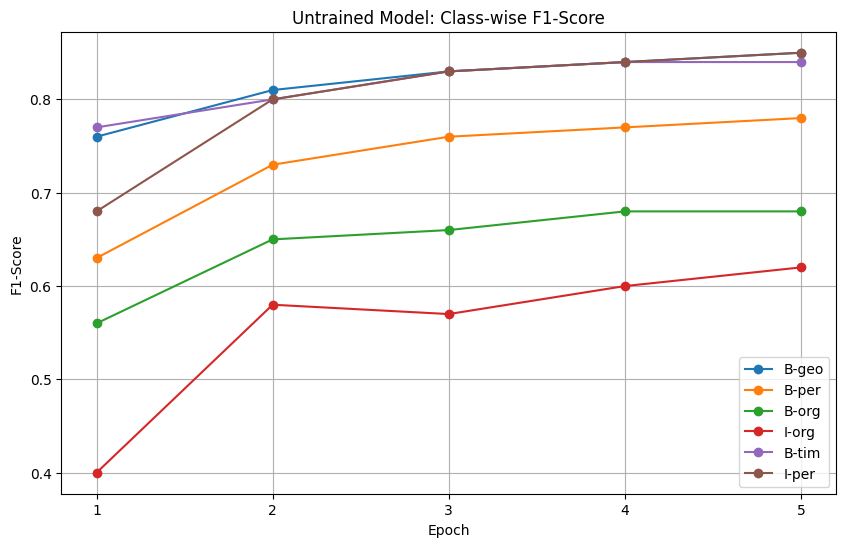

In [42]:

def plot_class_f1_scores(eval_reports, target_classes, epochs, title="Class-wise F1-Score"):
    """
    주어진 평가 결과(eval_reports)에서 특정 클래스들의 F1-Score 변화를 시각화.

    Args:
        eval_reports (list): 평가 결과 DataFrame 리스트.
        target_classes (list): 관심 있는 클래스 목록.
        epochs (int): 총 에포크 수.
        title (str): 그래프 제목.
    """
    # 클래스별 F1-Score 저장용 딕셔너리
    class_f1_scores = {cls: [] for cls in target_classes}

    # 평가 결과에서 관심 클래스의 F1-Score 추출
    for eval_df in eval_reports:
        for cls in target_classes:
            f1_score = eval_df.loc[eval_df['class'] == cls, 'f1_score'].values
            if len(f1_score) > 0:
                class_f1_scores[cls].append(f1_score[0])  # F1-Score 저장
            else:
                class_f1_scores[cls].append(0)  # 해당 에포크에서 데이터가 없을 경우 0으로 설정

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    for cls, scores in class_f1_scores.items():
        plt.plot(range(1, epochs + 1), scores, marker='o', label=cls)

    # 그래프 설정
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.xticks(range(1, epochs + 1))  # 에포크 숫자 표시
    plt.legend(loc='best')
    plt.grid()
    plt.show()



# 모든 Epoch가 끝난 후 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, Config.EPOCHS + 1), train_losses, label='Pre-trained Model')
plt.plot(range(1, Config.EPOCHS + 1), untrained_train_losses, label='Untrained Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


# 타겟 클래스 (지원 데이터가 2000건 이상인 클래스들)
target_classes = ['B-geo', 'B-per', 'B-org', 'I-org', 'B-tim', 'I-per']

# Pre-trained 모델 시각화
plot_class_f1_scores(eval_reports, target_classes, Config.EPOCHS, title="Pre-trained Model: Class-wise F1-Score")

# Untrained 모델 시각화
plot_class_f1_scores(untrained_eval_reports, target_classes, Config.EPOCHS, title="Untrained Model: Class-wise F1-Score")
